# 1. Load libraries


In [ ]:
!pip install torch torchvision torchaudio segmentation-models-pytorch albumentations --quiet
!pip install tqdm --quiet
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.metrics import accuracy_score
import time
import kagglehub
from tqdm import tqdm
import os
import cv2
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2. Download dataset

In [ ]:
path = kagglehub.dataset_download("pkdarabi/bone-fracture-detection-computer-vision-project")

print("Path to dataset files:", path)

100%|██████████| 84.1M/84.1M [00:00<00:00, 96.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2


In [ ]:
os.listdir(path)

['BoneFractureYolo8', 'bone fracture detection.v4-v4.yolov8']

In [ ]:
train_images = os.path.join(path, 'BoneFractureYolo8/train/images')
train_labels = os.path.join(path, 'BoneFractureYolo8/train/labels')
test_images = os.path.join(path, 'BoneFractureYolo8/test/images')
test_labels = os.path.join(path, 'BoneFractureYolo8/test/labels')
val_images = os.path.join(path, 'BoneFractureYolo8/valid/images')
val_labels = os.path.join(path, 'BoneFractureYolo8/valid/labels')

In [ ]:
train_image_files = os.listdir(path + "/BoneFractureYolo8/train/images")
train_label_files = os.listdir(path + "/BoneFractureYolo8/train/labels")
test_image_files = os.listdir(path + "/BoneFractureYolo8/test/images")
test_label_files = os.listdir(path + "/BoneFractureYolo8/test/labels")
val_image_files = os.listdir(path + "/BoneFractureYolo8/valid/images")
val_label_files = os.listdir(path + "/BoneFractureYolo8/valid/labels")

# 3. Exploratory Data Analysis

### Dataset size

In [ ]:
print(f"Number of training images: {len(train_image_files)}")
print(f"Number of training labels: {len(train_label_files)}")
print(f"Number of validation images: {len(val_image_files)}")
print(f"Number of validation labels: {len(val_label_files)}")
print(f"Number of test images: {len(test_image_files)}")
print(f"Number of test labels: {len(test_label_files)}")

Number of training images: 3631
Number of training labels: 3631
Number of validation images: 348
Number of validation labels: 348
Number of test images: 169
Number of test labels: 169


### Images of "No fracture"

In [ ]:
def check_empty_files(label_files, label_dir):
    empty_files = []
    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        if os.stat(label_path).st_size == 0:  # Check if the file size is 0
            empty_files.append(label_file)
    return empty_files

train_empty_labels = check_empty_files(train_label_files, train_labels)
val_empty_labels = check_empty_files(val_label_files, val_labels)
test_empty_labels = check_empty_files(test_label_files, test_labels)

print(f"Empty training label files: {len(train_empty_labels)}") #don't delete as empty label files means no fracture present in x-ray image
print(f"Empty validation label files: {len(val_empty_labels)}")
print(f"Empty test label files: {len(test_empty_labels)}")

Empty training label files: 1827
Empty validation label files: 175
Empty test label files: 86


### Class distribution

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

label_dir = train_labels

# Prepare a list to collect label info
label_data = []

# Parse each label file
for file in os.listdir(label_dir):
    if file.endswith(".txt"):
        with open(os.path.join(label_dir, file), "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 1:
                    class_id = int(parts[0])
                    label_data.append({
                        "filename": file,
                        "class_id": class_id,
                        "num_points": (len(parts) - 1) // 2
                    })

# Convert to DataFrame
label_df = pd.DataFrame(label_data)
label_df.head()


,filename,class_id,num_points
0,image1_4286_png.rf.7f3f4c1a87cc11973a6825cb6a9...,5,5
1,image2_193_png.rf.1dc82279c1c3105c441cb7f85568...,4,4
2,image1_1150_png.rf.33cf4786444bef50aef2ca04a02...,2,5
3,image1_5009_png.rf.4c21354df4178a157e86216e427...,5,4
4,image1_1746_png.rf.805aca8807c570ae42d50eb626f...,5,4


<ipython-input-35-4be5af045c0f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=label_df, x="class_id", palette="Set2")


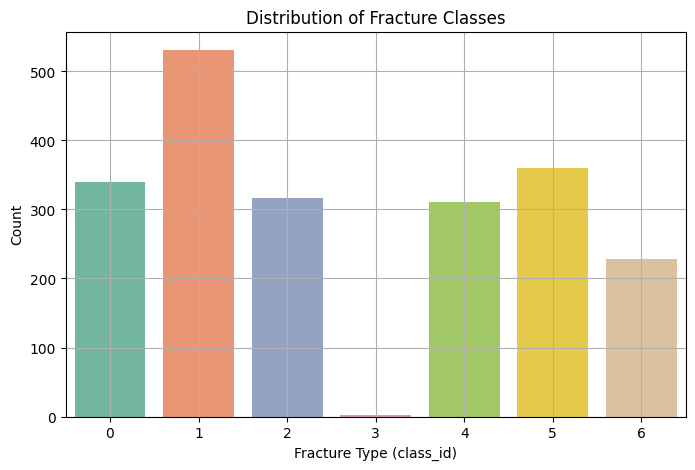

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=label_df, x="class_id", palette="Set2")
plt.title("Distribution of Fracture Classes")
plt.xlabel("Fracture Type (class_id)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


### Sample images

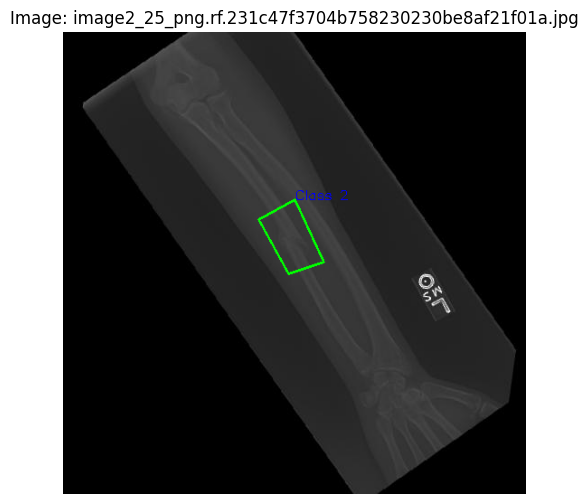

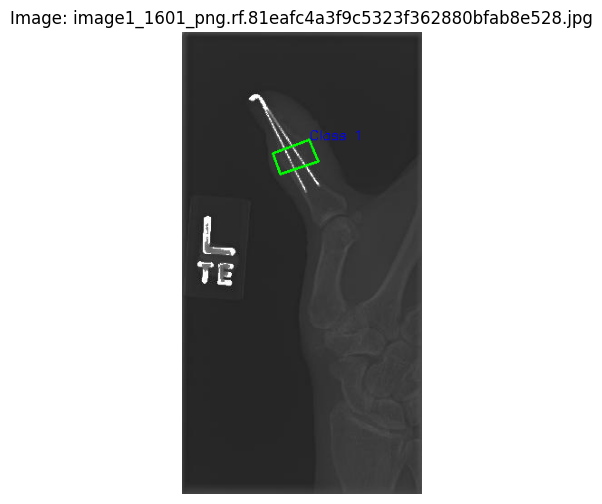

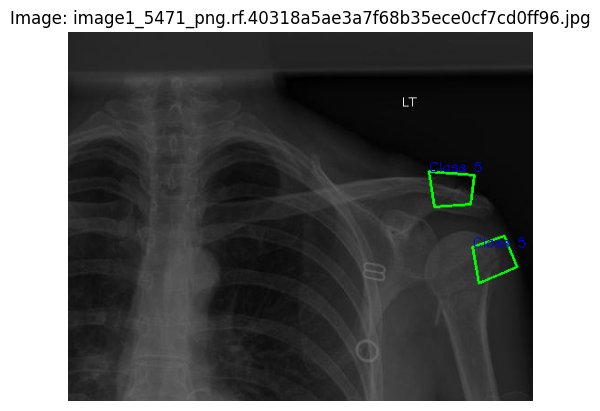

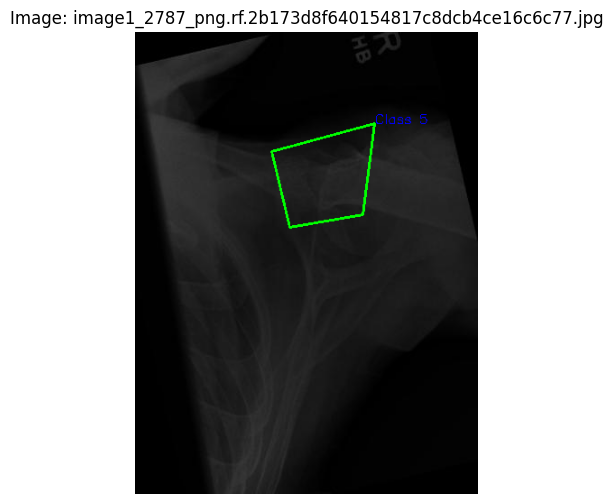

In [ ]:
import cv2
import numpy as np
import random

image_dir = train_images  # Replace with your actual path
sample_files = label_df['filename'].unique()
sample_files = random.sample(list(sample_files), 4)

for label_file in sample_files:
    image_file = label_file.replace(".txt", ".jpg")  # Adjust if you use .png
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, label_file)

    image = cv2.imread(image_path)
    if image is None:
        continue

    h, w, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            coords = list(map(float, line.strip().split()))
            class_id = int(coords[0])
            polygon = np.array(coords[1:]).reshape(-1, 2)
            polygon[:, 0] *= w
            polygon[:, 1] *= h
            polygon = polygon.astype(np.int32)
            cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
            cv2.putText(image, f"Class {class_id}", tuple(polygon[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_file}")
    plt.axis("off")
    plt.show()


# 4. Preprocessing


In [ ]:
num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}



In [ ]:
class FractureDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]  # Get all label files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)

        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the corresponding label file (if exists)
        label_name = image_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.label_dir, label_name)

        # Initialize labels as an empty list (for no fracture)
        labels = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_data = f.read().strip().split("\n")
                if label_data and label_data[0] != '':
                    labels = [[float(val) for val in line.split()] for line in label_data]

        # Apply transformations if provided
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        # Handle cases where label file is empty (no fracture)
        if not labels:
            binary_label = torch.tensor(0, dtype=torch.float32)  # No fracture: 0
            multiclass_label = torch.tensor(0, dtype=torch.long)  # Class 0 for no fracture
        else:
            binary_label = torch.tensor(1, dtype=torch.float32)  # Fracture: 1
            # Assuming the first element is the class label
            multiclass_label = torch.tensor(int(labels[0][0]), dtype=torch.long)

        # Create segmentation mask
        segmentation_mask = torch.zeros_like(image[0], dtype=torch.float32)
        if labels:
            # Rescale coordinates to match image size after transformations
            h, w = image.shape[1], image.shape[2]
            polygon_points = [[int(labels[0][i + 1] * w), int(labels[0][i + 2] * h)]  # x, y coordinates
                            for i in range(0, len(labels[0]) - 1, 2)]
            polygon_points = np.array(polygon_points, dtype=np.int32)

            # Fill the polygon in the mask with 1
            cv2.fillPoly(segmentation_mask.cpu().numpy(), [polygon_points], 1)
            segmentation_mask = torch.from_numpy(segmentation_mask.cpu().numpy())

        return image, binary_label, multiclass_label, segmentation_mask

# Define image transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # A.Grayscale(num_output_channels=1),
    ToTensorV2()
])

print("Dataset class defined successfully.")


Dataset class defined successfully.


In [ ]:
import torch.multiprocessing as mp

In [ ]:
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)  # Set start method to 'spawn'

    # Create dataset instances
    train_dataset = FractureDataset(train_images, train_labels, transform=transform)
    val_dataset = FractureDataset(val_images, val_labels, transform=transform)
    test_dataset = FractureDataset(test_images, test_labels, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Check dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 3631
Validation samples: 348
Test samples: 169


# 5. Defining the Model

In [ ]:
class MultiTaskFractureModel(nn.Module):
    def __init__(self, num_classes=7):
        super(MultiTaskFractureModel, self).__init__()

        # Backbone using a pre-trained encoder (EfficientNet-B0)
        self.encoder = smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", in_channels=3, classes=1)

        # Get the number of features from the encoder's output
        encoder_output_features = self.encoder.encoder._out_channels[-1]

        # Binary classification head (Fracture vs No Fracture)
        self.binary_classifier = nn.Linear(encoder_output_features, 1)

        # Multi-class classification head (Fracture type)
        self.multi_classifier = nn.Linear(encoder_output_features, num_classes)

    def forward(self, x):
        features = self.encoder.encoder(x)  # Extract features from encoder

        # Global Average Pooling
        pooled_features = F.adaptive_avg_pool2d(features[-1], (1, 1)).view(x.size(0), -1)

        # Binary classification output
        binary_output = torch.sigmoid(self.binary_classifier(pooled_features))

        # Multi-class classification output
        multi_output = self.multi_classifier(pooled_features)

        # Segmentation output
        segmentation_output = self.encoder(x)  # U-Net segmentation output

        return binary_output, multi_output, segmentation_output

In [ ]:
model = MultiTaskFractureModel().to(device)
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 124MB/s] 


MultiTaskFractureModel(
  (encoder): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_pa

In [ ]:
binary_loss_fn = nn.BCEWithLogitsLoss()
multiclass_loss_fn = nn.CrossEntropyLoss()
segmentation_loss_fn = DiceLoss(mode='binary')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# 6. Model Training

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0
        val_loss = 0.0

        # Training Phase with tqdm
        print(f"\nEpoch {epoch+1}/{epochs} - Training:")
        for images, binary_labels, multiclass_labels, segmentation_masks in tqdm(train_loader, desc="Training", leave=False):
            images, binary_labels, multiclass_labels, segmentation_masks = (
                images.to(device), binary_labels.to(device),
                multiclass_labels.to(device), segmentation_masks.to(device)
            )
            optimizer.zero_grad()

            binary_pred, multi_pred, segmentation_pred = model(images)

            # Compute losses
            binary_loss = binary_loss_fn(binary_pred.squeeze(), binary_labels.float())
            multi_loss = multiclass_loss_fn(multi_pred, multiclass_labels)
            segmentation_loss = segmentation_loss_fn(segmentation_pred, segmentation_masks.float())

            loss = binary_loss + multi_loss + segmentation_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Phase with tqdm
        model.eval()
        all_binary_preds, all_binary_labels = [], []
        all_multi_preds, all_multi_labels = [], []
        dice_scores, iou_scores = [], []

        print(f"\nEpoch {epoch+1}/{epochs} - Validation:")
        with torch.no_grad():
            for images, binary_labels, multiclass_labels, segmentation_masks in tqdm(val_loader, desc="Validation", leave=False):
                images, binary_labels, multiclass_labels, segmentation_masks = (
                    images.to(device), binary_labels.to(device),
                    multiclass_labels.to(device), segmentation_masks.to(device)
                )

                binary_pred, multi_pred, segmentation_pred = model(images)

                # Compute losses
                binary_loss = binary_loss_fn(binary_pred.squeeze(), binary_labels.float())
                multi_loss = multiclass_loss_fn(multi_pred, multiclass_labels)
                segmentation_loss = segmentation_loss_fn(segmentation_pred, segmentation_masks.float())

                val_loss += (binary_loss + multi_loss + segmentation_loss).item()

                # Convert predictions for evaluation
                all_binary_preds.extend((binary_pred.squeeze() > 0.5).cpu().numpy())
                all_binary_labels.extend(binary_labels.cpu().numpy())

                all_multi_preds.extend(multi_pred.argmax(dim=1).cpu().numpy())
                all_multi_labels.extend(multiclass_labels.cpu().numpy())

                dice_scores.append(1 - segmentation_loss.item())
                iou_scores.append((1 - segmentation_loss.item()) / (2 - segmentation_loss.item()))

        # Compute metrics
        binary_accuracy = accuracy_score(all_binary_labels, all_binary_preds)
        multi_accuracy = accuracy_score(all_multi_labels, all_multi_preds)
        mean_dice = sum(dice_scores) / len(dice_scores)
        mean_iou = sum(iou_scores) / len(iou_scores)

        print(f"\nEpoch {epoch+1}/{epochs} - Time: {time.time()-start_time:.2f}s")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Binary Acc: {binary_accuracy:.4f} | Multi Acc: {multi_accuracy:.4f} | Dice: {mean_dice:.4f} | IoU: {mean_iou:.4f}\n")



In [ ]:
train_model(model, train_loader, val_loader, epochs=20)


Epoch 1/20 - Training:



Epoch 1/20 - Validation:



Epoch 1/20 - Time: 142.44s
Train Loss: 2.9439 | Val Loss: 2.3465
Binary Acc: 0.7270 | Multi Acc: 0.7557 | Dice: 0.1853 | IoU: 0.1453


Epoch 2/20 - Training:



Epoch 2/20 - Validation:



Epoch 2/20 - Time: 99.01s
Train Loss: 1.7795 | Val Loss: 1.9584
Binary Acc: 0.7816 | Multi Acc: 0.7816 | Dice: 0.2919 | IoU: 0.2080


Epoch 3/20 - Training:



Epoch 3/20 - Validation:



Epoch 3/20 - Time: 99.37s
Train Loss: 1.2452 | Val Loss: 2.0520
Binary Acc: 0.7816 | Multi Acc: 0.7701 | Dice: 0.2922 | IoU: 0.2087


Epoch 4/20 - Training:



Epoch 4/20 - Validation:



Epoch 4/20 - Time: 99.47s
Train Loss: 1.1693 | Val Loss: 2.1742
Binary Acc: 0.7701 | Multi Acc: 0.7644 | Dice: 0.3316 | IoU: 0.2364


Epoch 5/20 - Training:



Epoch 5/20 - Validation:



Epoch 5/20 - Time: 99.10s
Train Loss: 1.0006 | Val Loss: 2.1474
Binary Acc: 0.8305 | Multi Acc: 0.7960 | Dice: 0.2836 | IoU: 0.2029


Epoch 6/20 - Training:



Epoch 6/20 - Validation:



Epoch 6/20 - Time: 99.21s
Train Loss: 0.9354 | Val Loss: 2.1633
Binary Acc: 0.8161 | Multi Acc: 0.8103 | Dice: 0.3195 | IoU: 0.2238


Epoch 7/20 - Training:



Epoch 7/20 - Validation:



Epoch 7/20 - Time: 99.52s
Train Loss: 0.9172 | Val Loss: 2.4675
Binary Acc: 0.8161 | Multi Acc: 0.7759 | Dice: 0.3146 | IoU: 0.2258


Epoch 8/20 - Training:



Epoch 8/20 - Validation:



Epoch 8/20 - Time: 99.00s
Train Loss: 0.9558 | Val Loss: 2.4628
Binary Acc: 0.8305 | Multi Acc: 0.7500 | Dice: 0.2902 | IoU: 0.2070


Epoch 9/20 - Training:



Epoch 9/20 - Validation:



Epoch 9/20 - Time: 98.91s
Train Loss: 0.8495 | Val Loss: 2.3704
Binary Acc: 0.8132 | Multi Acc: 0.8075 | Dice: 0.3146 | IoU: 0.2222


Epoch 10/20 - Training:



Epoch 10/20 - Validation:



Epoch 10/20 - Time: 99.29s
Train Loss: 0.8677 | Val Loss: 2.1585
Binary Acc: 0.8391 | Multi Acc: 0.7960 | Dice: 0.3393 | IoU: 0.2369


Epoch 11/20 - Training:



Epoch 11/20 - Validation:



Epoch 11/20 - Time: 99.30s
Train Loss: 0.8751 | Val Loss: 2.2165
Binary Acc: 0.8420 | Multi Acc: 0.7960 | Dice: 0.3281 | IoU: 0.2280


Epoch 12/20 - Training:



Epoch 12/20 - Validation:



Epoch 12/20 - Time: 98.90s
Train Loss: 0.7991 | Val Loss: 2.3980
Binary Acc: 0.8391 | Multi Acc: 0.7931 | Dice: 0.3451 | IoU: 0.2410


Epoch 13/20 - Training:



Epoch 13/20 - Validation:



Epoch 13/20 - Time: 99.30s
Train Loss: 0.8072 | Val Loss: 2.4444
Binary Acc: 0.7816 | Multi Acc: 0.8017 | Dice: 0.3036 | IoU: 0.2127


Epoch 14/20 - Training:



Epoch 14/20 - Validation:



Epoch 14/20 - Time: 99.06s
Train Loss: 0.7999 | Val Loss: 2.6675
Binary Acc: 0.8161 | Multi Acc: 0.7615 | Dice: 0.2777 | IoU: 0.2005


Epoch 15/20 - Training:



Epoch 15/20 - Validation:



Epoch 15/20 - Time: 98.99s
Train Loss: 0.7383 | Val Loss: 2.3260
Binary Acc: 0.8362 | Multi Acc: 0.7989 | Dice: 0.3352 | IoU: 0.2358


Epoch 16/20 - Training:



Epoch 16/20 - Validation:



Epoch 16/20 - Time: 99.89s
Train Loss: 0.7474 | Val Loss: 2.3669
Binary Acc: 0.8333 | Multi Acc: 0.7902 | Dice: 0.3286 | IoU: 0.2317


Epoch 17/20 - Training:



Epoch 17/20 - Validation:



Epoch 17/20 - Time: 99.34s
Train Loss: 0.8113 | Val Loss: 2.8943
Binary Acc: 0.7040 | Multi Acc: 0.6724 | Dice: 0.2658 | IoU: 0.1923


Epoch 18/20 - Training:



Epoch 18/20 - Validation:



Epoch 18/20 - Time: 98.91s
Train Loss: 0.7609 | Val Loss: 2.3745
Binary Acc: 0.8391 | Multi Acc: 0.8046 | Dice: 0.3049 | IoU: 0.2172


Epoch 19/20 - Training:



Epoch 19/20 - Validation:



Epoch 19/20 - Time: 99.07s
Train Loss: 0.7295 | Val Loss: 2.2461
Binary Acc: 0.8448 | Multi Acc: 0.8190 | Dice: 0.3162 | IoU: 0.2254


Epoch 20/20 - Training:



Epoch 20/20 - Validation:



Epoch 20/20 - Time: 99.12s
Train Loss: 0.7349 | Val Loss: 2.5366
Binary Acc: 0.8132 | Multi Acc: 0.7816 | Dice: 0.2770 | IoU: 0.1990



# 7. Evaluation

In [ ]:
model.eval()

# Initialize lists for evaluation
all_binary_preds, all_binary_labels = [], []
all_multi_preds, all_multi_labels = [], []
dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, binary_labels, multiclass_labels, segmentation_masks in test_loader:
        images, binary_labels, multiclass_labels, segmentation_masks = (
            images.to(device), binary_labels.to(device),
            multiclass_labels.to(device), segmentation_masks.to(device)
        )

        binary_pred, multi_pred, segmentation_pred = model(images)

        # Convert predictions for evaluation
        binary_pred = (binary_pred.squeeze() > 0.5).cpu().numpy()
        multi_pred = multi_pred.argmax(dim=1).cpu().numpy()
        segmentation_pred_binary = (segmentation_pred > 0.5).cpu().numpy()

        # Append for metric calculation
        all_binary_preds.extend(binary_pred.tolist() if binary_pred.ndim > 0 else [binary_pred.item()])
        all_binary_labels.extend(binary_labels.cpu().numpy())
        all_multi_preds.extend(multi_pred)
        all_multi_labels.extend(multiclass_labels.cpu().numpy())

        # Compute Dice and IoU
        dice_score = 1 - segmentation_loss_fn(segmentation_pred.cpu().float(), segmentation_masks.cpu().float()).item()

        dice_scores.append(dice_score)

        iou_score = dice_score / (2 - dice_score)
        iou_scores.append(iou_score)

# Compute final metrics
binary_accuracy = accuracy_score(all_binary_labels, all_binary_preds)
multi_accuracy = accuracy_score(all_multi_labels, all_multi_preds)
mean_dice = sum(dice_scores) / len(dice_scores)
mean_iou = sum(iou_scores) / len(iou_scores)

print(f"Test Set Evaluation:")
print(f"Binary Accuracy (Fracture vs No Fracture): {binary_accuracy:.4f}")
print(f"Multi-Class Accuracy (Fracture Type): {multi_accuracy:.4f}")
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")


Test Set Evaluation:
Binary Accuracy (Fracture vs No Fracture): 0.7751
Multi-Class Accuracy (Fracture Type): 0.7692
Mean Dice Score: 0.3071
Mean IoU Score: 0.1987


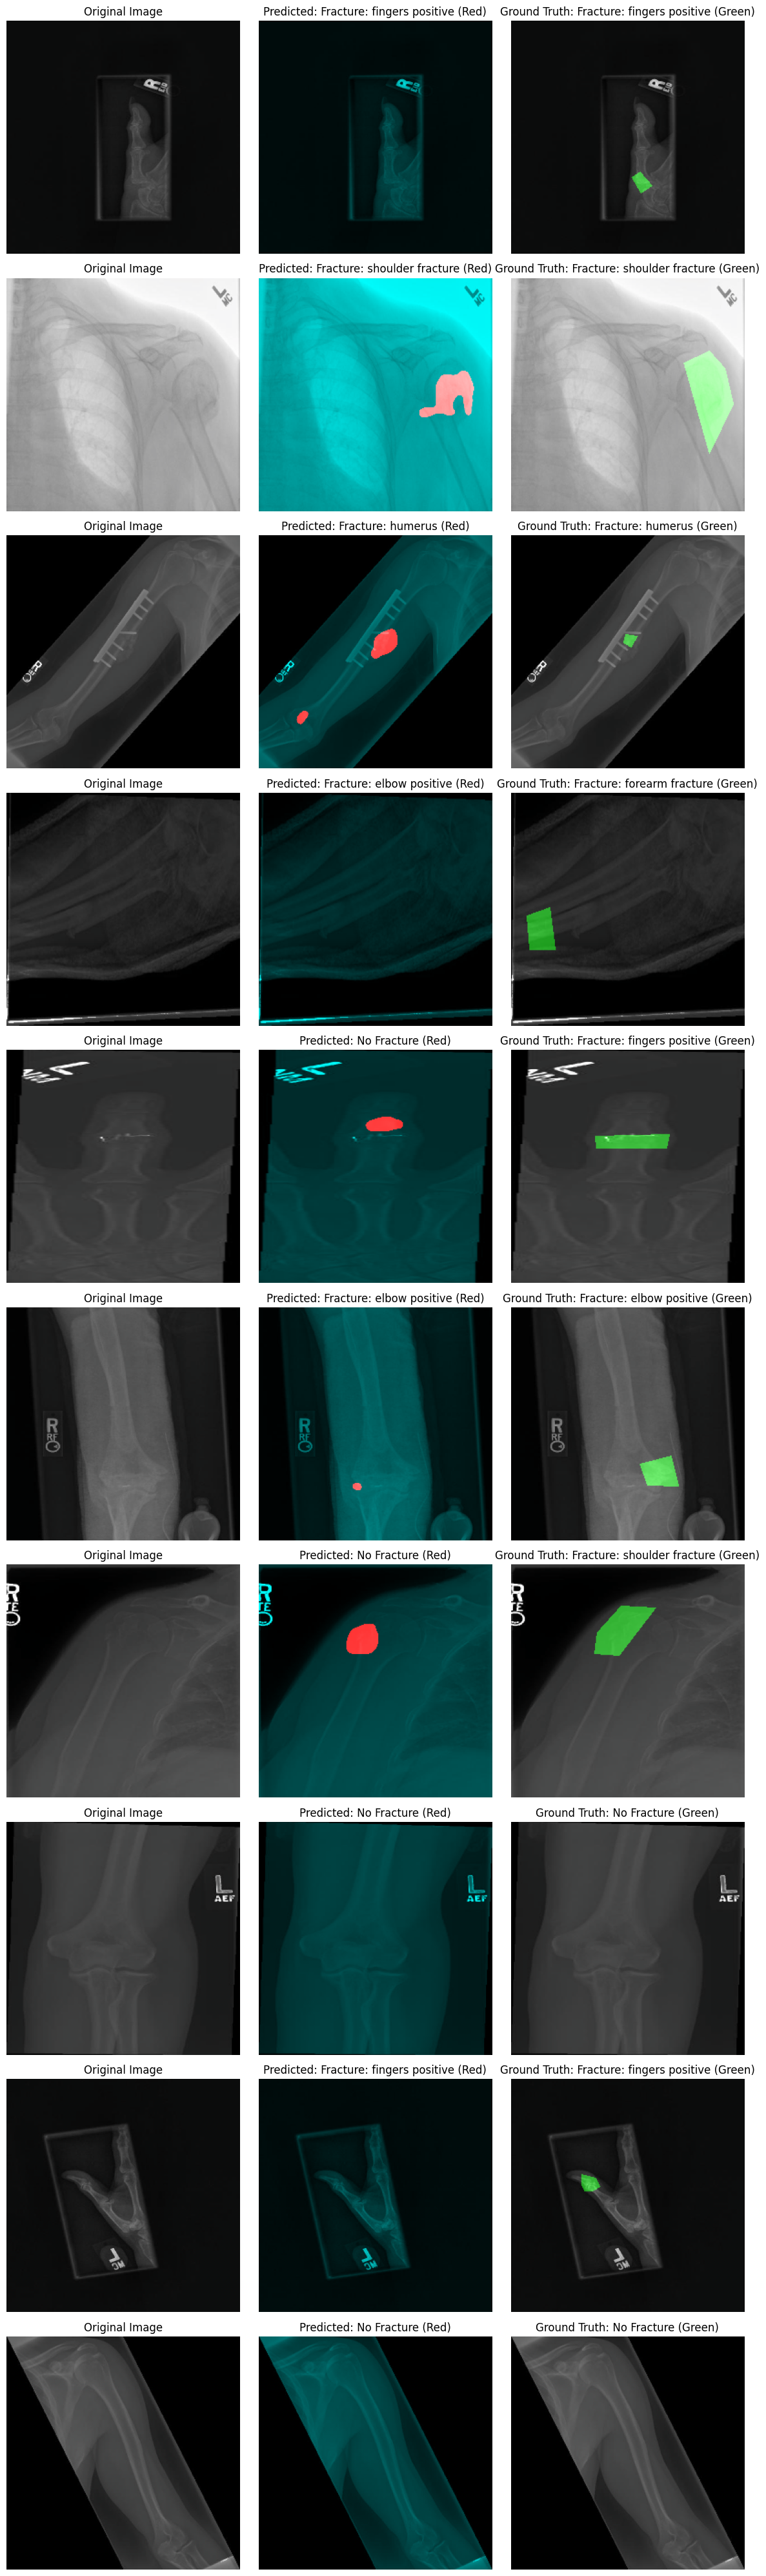

In [ ]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.clone().permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
    image = image * np.array(std) + np.array(mean)  # Reverse normalization
    image = np.clip(image, 0, 1)  # Clip values between 0 and 1
    return image

# Select random samples from test set
num_samples = 10  # Changed to 10 samples
indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

for i, idx in enumerate(indices):
    # Load sample
    image, binary_label, multiclass_label, segmentation_mask = test_dataset[idx]

    # Move to device and add batch dimension
    image_tensor = image.unsqueeze(0).to(device)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        binary_pred, multi_pred, segmentation_pred = model(image_tensor)

    # Convert predictions
    binary_pred = (binary_pred.item() > 0.5)
    multi_pred = multi_pred.argmax(dim=1).item()
    segmentation_pred = segmentation_pred.squeeze().cpu().numpy()

    # Convert image to displayable format
    original_image = denormalize(image)

    # Overlay the predicted mask on the original image
    predicted_overlay = original_image.copy()
    predicted_overlay[:, :, 0] += segmentation_pred * 0.5  # Highlight in red

    # Overlay the ground truth mask on the original image
    ground_truth_overlay = original_image.copy()
    ground_truth_overlay[:, :, 1] += segmentation_mask.squeeze().cpu().numpy() * 0.5  # Highlight in green

    # Plot original image
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Plot predicted fracture location
    axes[i, 1].imshow(predicted_overlay)

    # Add fracture information to title
    fracture_info = "No Fracture"
    if binary_pred:
        fracture_info = f"Fracture: {l2c[multi_pred]}"  # Using l2c to get fracture type name
    axes[i, 1].set_title(f"Predicted: {fracture_info} (Red)")
    axes[i, 1].axis("off")

    # Plot ground truth fracture location
    axes[i, 2].imshow(ground_truth_overlay)

    # Add fracture information to title
    fracture_info = "No Fracture"
    if binary_label == 1:  # Check binary label for ground truth
        fracture_info = f"Fracture: {l2c[multiclass_label.item()]}"
    axes[i, 2].set_title(f"Ground Truth: {fracture_info} (Green)")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()